# Basic characterizations of LA Q1
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 4 # for LA Q1
res_index = 4 # for LA Q1
flux_index = 4 # for LA Q1
TLS_index = 0 # for TLS of interest

2024-03-20 09:38:04,923 - qm - INFO     - Starting session: ad56af4c-8a7c-498f-aa79-c0e9722611cf


In [121]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [3]:
# Set all DC bias to 0
for i in np.arange(7):
    val = machine.flux_lines[i].dc_voltage       
    machine.flux_lines[i].dc_voltage -= val
machine = Analysis.set_machine(machine)

In [4]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [5]:
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [6]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-03-20 09:39:51,773 - qm - INFO     - Octave "octave1" Health check passed, current temperature 58


INFO:qm:Octave "octave1" Health check passed, current temperature 58


2024-03-20 09:39:51,778 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 09:39:51,796 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r4 for (LO, IF) = (6.276 GHz, -50.000 MHz)
2024-03-20 09:40:00,178 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q4 for (LO, IF) = (4.635 GHz, -50.000 MHz)
2024-03-20 09:40:13,568 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Time of flight

DC offset to add to I: 0.000268 V
DC offset to add to Q: 0.000105 V
TOF to add: 8.0 ns


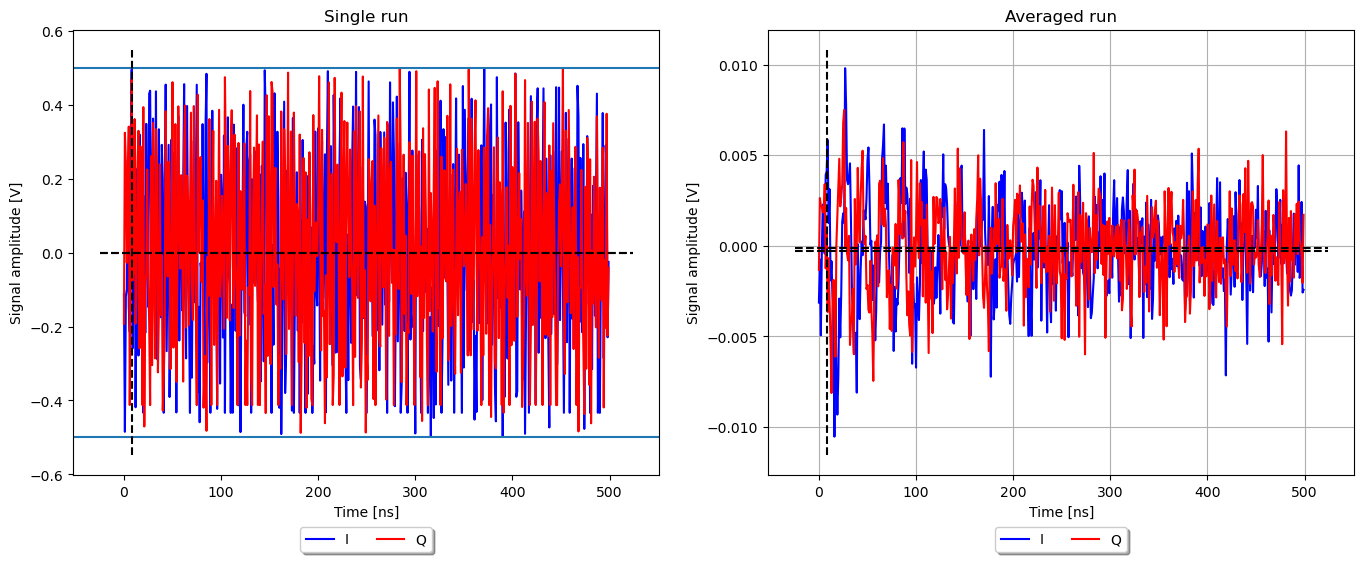

In [25]:
# time_of_flight
# experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 10E3, cd_time = 10E3, simulate_flag = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [26]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += dc_offset_i.item()
machine.global_parameters.con1_downconversion_offset_Q += dc_offset_q.item()
#machine.global_parameters.time_of_flight = 304-0
machine = Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

In [27]:
%matplotlib qt
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-10E6,10E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                            n_avg = 1E3, cd_time = 5E3, readout_state = 'g', simulate_flag = False, simulation_len = 1000)
# Readout in excited state
# machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
#                           n_avg = 1E3, cd_time = 5E3, readout_state = 'e', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.06s


resonator frequency: 6226.313 MHz
Execution stopped by user!


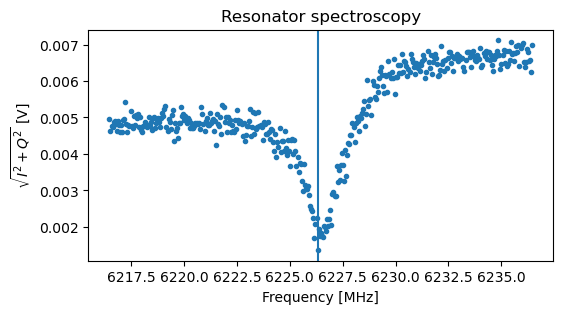

In [28]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
machine.resonators[res_index].lo = res_freq.tolist() + 50E6
machine = Analysis.set_machine(machine)

In [29]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-03-20 09:46:29,852 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 09:46:29,873 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r4 for (LO, IF) = (6.276 GHz, -50.000 MHz)
2024-03-20 09:46:37,671 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q4 for (LO, IF) = (4.635 GHz, -50.000 MHz)
2024-03-20 09:46:51,535 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## 2D RO resonator spectroscopy vs DC flux

In [30]:
res_freq_sweep = np.arange(6.212E9,6.230E9 + 1.0,0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.5)
%matplotlib qt
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, n_avg = 10E3, cd_time = 10E3)

Progress: [##################################################] 100.0% (n=37/37)


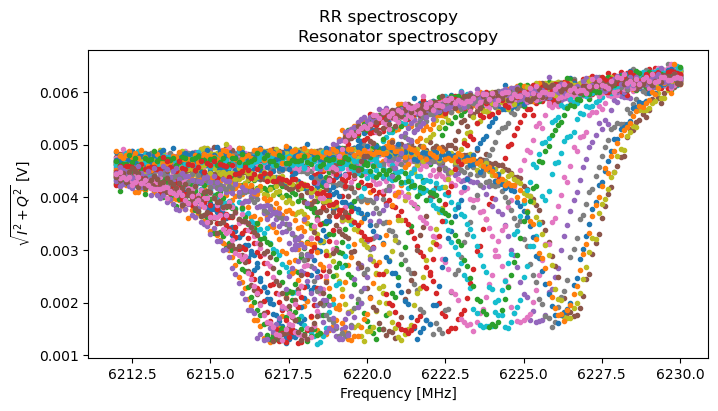

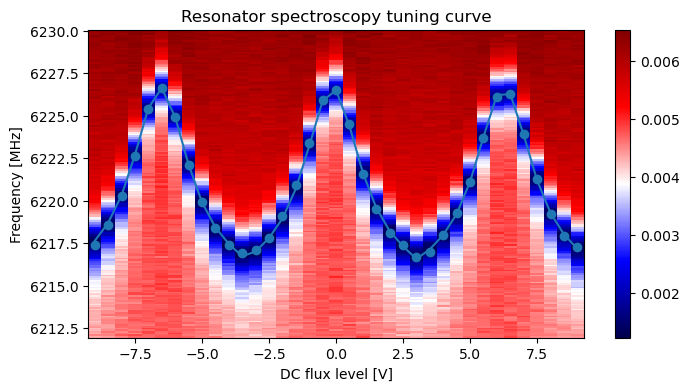

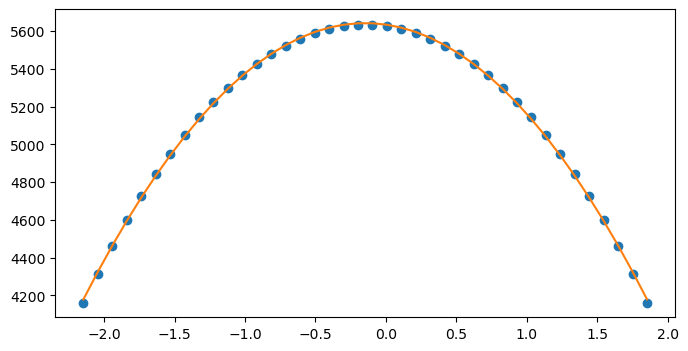

Execution stopped by user!


In [31]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = [6227, 200, 30E3, 0.05, 0.4, 100])
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

In [32]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [33]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].DC_tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [34]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 57.61s
Progress: [##################################################] 100.0% (n=50000/50000.0) --> elapsed time: 57.66s
resonator frequency: 6226.641 MHz


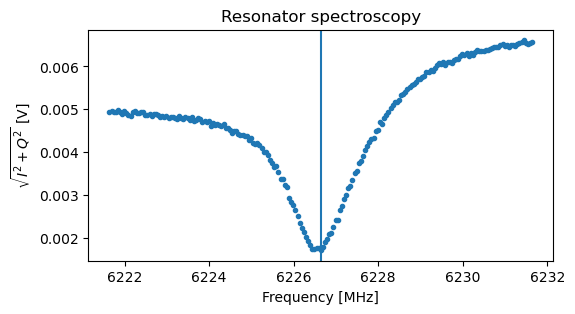

In [35]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 50E3, cd_time = 5E3, plot_flag = False, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [270]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index)

2024-02-08 15:51:47,993 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-08 15:51:48,008 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r4 for (LO, IF) = (6.277 GHz, -50.000 MHz)
2024-02-08 15:51:54,900 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q4 for (LO, IF) = (5.750 GHz, -50.000 MHz)
2024-02-08 15:52:06,917 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [123]:
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag=True)

2024-03-20 12:11:42,789 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 12:11:42,794 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r4 for (LO, IF) = (6.277 GHz, -50.000 MHz)
2024-03-20 12:11:50,495 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q4 for (LO, IF) = (5.782 GHz, -50.000 MHz)
2024-03-20 12:12:04,252 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [124]:
if True: # for the DC flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
else: # for the fast flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz
    
qubit_freq_sweep = int(qubit_freq_est) + np.arange(0E6, 250E6 + 1, 1E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1, ff_amp = 0.0, n_avg = 10E3, cd_time = 25E3, plot_flag = False, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 65.38s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 65.42s


resonant frequency: 5731.358 MHz


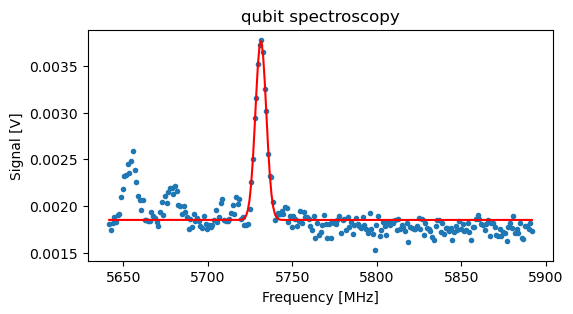

In [127]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].f_tls[0] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq + 50E6
machine = Analysis.set_machine(machine)

In [49]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine)

2024-03-20 10:12:43,943 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 10:12:43,954 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r4 for (LO, IF) = (6.277 GHz, -50.000 MHz)
2024-03-20 10:12:51,610 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q4 for (LO, IF) = (5.782 GHz, -50.000 MHz)
2024-03-20 10:13:05,820 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Rabi

### time rabi

In [68]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 40 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 25E3, plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 9.37s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 9.42s


rabi_pi_pulse: 98.1 ns
half period: 99.91 ns


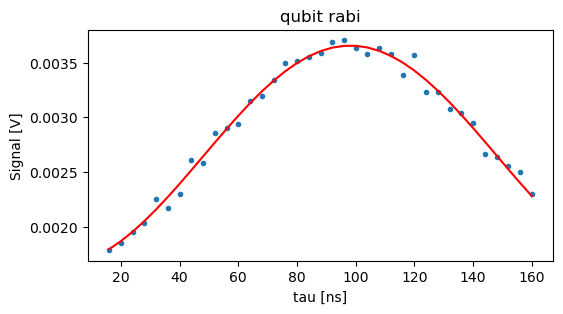

In [69]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [52]:
machine.qubits[qubit_index].pi_length[0] = 100
# machine.qubits[qubit_index].pi_amp[0] = 0.01
machine = Analysis.set_machine(machine)

### power rabi

In [65]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 2, 0.02) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                                          n_avg = 10E3, cd_time = 25E3, plot_flag = False, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 23.16s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 23.21s


rabi_pi_pulse_amp: 0.02269 V
half period: 0.0207680 V


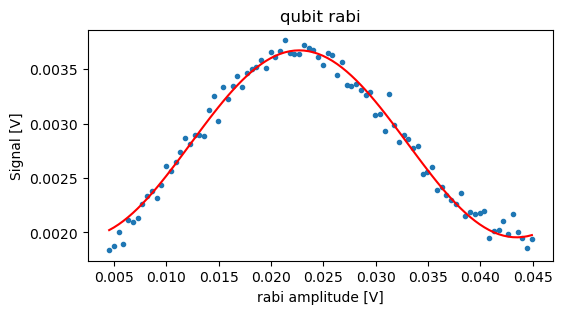

In [66]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [67]:
machine.qubits[qubit_index].pi_amp[0] = pi_pulse_amp.item()
machine = Analysis.set_machine(machine)

## T1

In [70]:
%matplotlib qt
tau_sweep_abs = np.arange(100,50E3+1,300)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.qubit_T1(tau_sweep_abs, qubit_index, res_index, flux_index, 
                   n_avg = 5E3, cd_time = 100E3, simulate_flag = False, simulation_len = 15_000, plot_flag = False)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 104.77s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 104.81s


Qubit T1 [us]: 2.3200813793336215


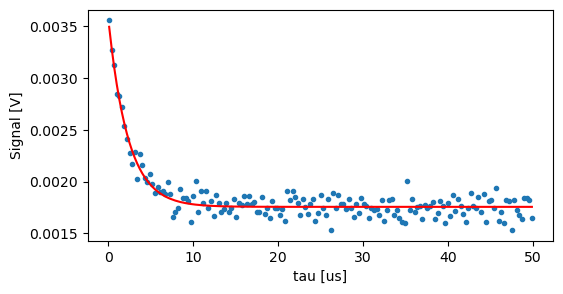

In [71]:
%matplotlib inline
q_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")
machine.qubits[qubit_index].T1 = int(q_T1.tolist())
machine = Analysis.set_machine(machine)

## Ramsey

In [72]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 1000 + 0.1, 5)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_amp = Experiment.exp1D.Ramsey.ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, 
          n_avg = 10E3, detuning = 2E6, cd_time = 25E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 55.43s
Execution stopped by user!


Qubit T2* [ns]: 756.9064967128026
Detuning [MHz]: 2.6425920000806076
Exponent n: 2.1762624684890866


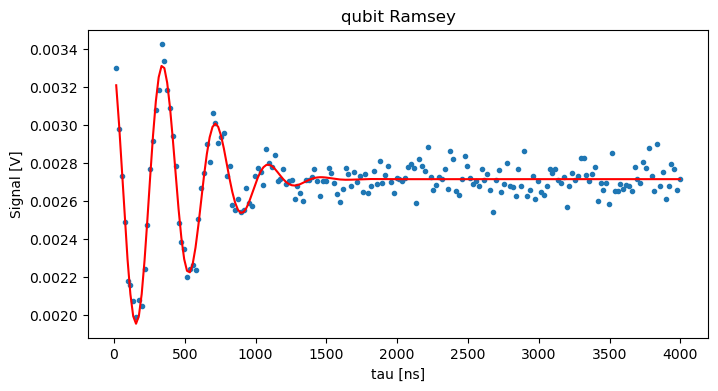

In [73]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, sig_amp,plot_flag = True)
machine.qubits[qubit_index].T2 = int(q_T2star.tolist())
machine = Analysis.set_machine(machine)

## ef transition

### ef frequency

In [ ]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-200E6, -150E6 + 1, 0.5E6) 
machine, ef_freq_sweep, sig_amp = Experiment.exp1D.Rabi.ef_freq(ef_freq_sweep, qubit_index, res_index, flux_index, 
                      pi_amp_rel = 1, pi_amp_rel_ef = 1.0, n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, 
                      simulate_flag = False, simulation_len = 4000)

In [ ]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(x=ef_freq_sweep,y=sig_amp,method="gaussian")

In [ ]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - int(ef_freq)
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_length[1] = 80
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 3.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.ef_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine,
                          simulate_flag = False, simulation_len = 1000)

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_amp[1] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## 2D qubit spectroscopy vs dc flux

In [131]:
machine = Analysis.get_machine()

In [132]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.16,0.16+1E-4,0.02)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                 n_avg = 5E3, cd_time = 15E3, pi_amp_rel = 1.0, plot_flag = True)

Progress: [##################################################] 100.0% (n=17/17) --> elapsed time: 558.05s


In [133]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2, plot_flag = False)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist() + 0E1
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

sweet spot flux: -0.12731 V


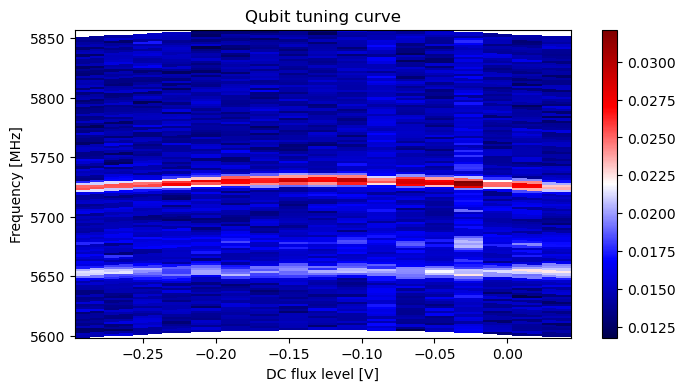

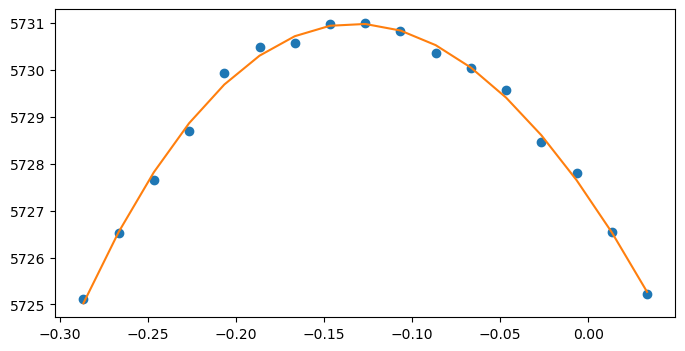

Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


In [134]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

## 2D qubit spectroscopy vs fast flux

In [135]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)

### slow version, compiling 1D scans

In [136]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

2024-03-20 12:33:52,112 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 12:33:52,122 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


In [150]:
# try the experiment
%matplotlib qt
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.25+1E-4,0.05)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 1E6)
if False: # first time running this, no AC_tuning_curve
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = 4.75, machine = machine, n_avg = 1E3, cd_time = 10E3, pi_amp_rel = 1.0, plot_flag = True)
else: # after the first run 
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, machine = machine, n_avg = 1E3, cd_time = 10E3, pi_amp_rel = 1.0, plot_flag = True)

2024-03-20 12:49:50,878 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 12:49:50,889 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q4 for (LO, IF) = (5.438 GHz, 290.000 MHz)
2024-03-20 12:49:56,573 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-03-20 12:50:36,511 - qm - INFO     - Performing health check.3% (n=5/6) --> elapsed time: 45.70s


INFO:qm.api.frontend_api:Performing health check


2024-03-20 12:50:36,517 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q4 for (LO, IF) = (5.178 GHz, 290.000 MHz)
2024-03-20 12:50:42,401 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=6/6) --> elapsed time: 75.67s


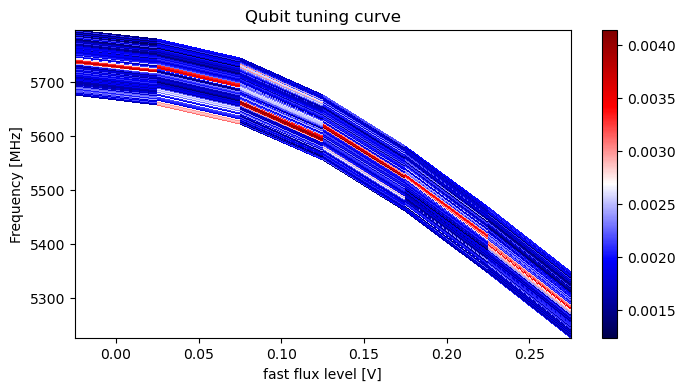

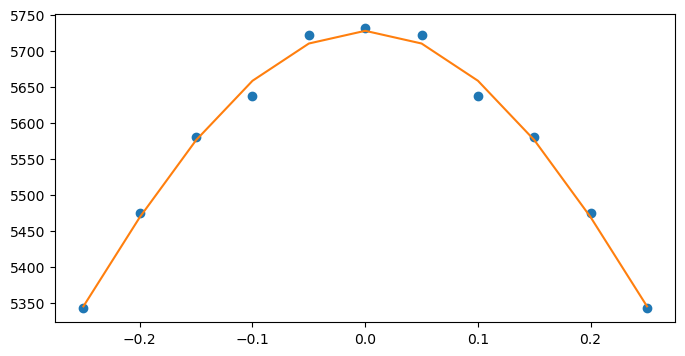

Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


In [151]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### fast version, runs blockwise 2D sweeps

In [166]:
machine = Analysis.get_machine()

In [167]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4.2E9, -5E6)
#qubit_freq_sweep = np.arange(q_freq_max,4E9,-100E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index, n_avg = 4E3, cd_time = 20E3, plot_flag = True)

2024-03-20 13:18:23,206 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 13:18:23,220 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q4 for (LO, IF) = (5.417 GHz, 200.000 MHz)
2024-03-20 13:18:29,049 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 812.83s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 812.99s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 812.88s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 813.03s
2024-03-20 13:46:01,162 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 13:46:01,174 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q4 for (LO, IF) = (5.217 GHz, 200.000 MHz)
2024-03-20 13:46:06,759 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 812.83s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 812.99s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 812.87s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 813.03s
2024-03-20 14:13:40,396 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 14:13:40,410 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q4 for (LO, IF) = (4.617 GHz, 200.000 MHz)
2024-03-20 14:13:45,958 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 812.81s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 812.98s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 812.69s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 812.85s
2024-03-20 14:41:19,084 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-20 14:41:19,098 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q4 for (LO, IF) = (4.417 GHz, 200.000 MHz)
2024-03-20 14:41:24,810 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 812.80s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 812.96s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 487.57s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 487.74s
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


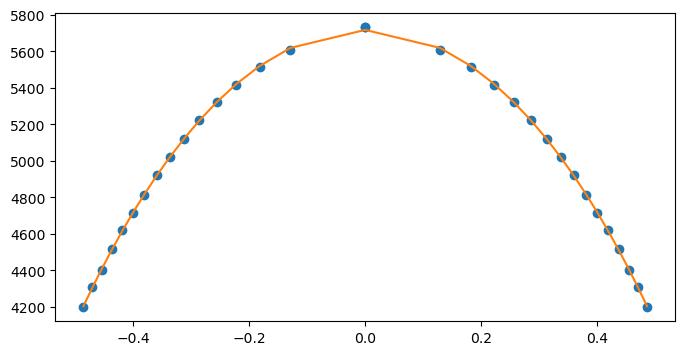

In [164]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
#machine.qubits[qubit_index].AC_tuning_curve = [-4245.549395948013,0.0,-6707.594982241495,0.0,6413.009439410573]
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

# TLS experiments

## TLS SWAP spectroscopy

In [91]:
machine = Analysis.get_machine()
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True, machine = machine)

2024-01-23 15:32:10,395 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-23 15:32:10,410 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r4 for (LO, IF) = (6.277 GHz, -50.000 MHz)
2024-01-23 15:32:17,085 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q4 for (LO, IF) = (3.874 GHz, -50.000 MHz)
2024-01-23 15:32:29,570 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


KeyboardInterrupt: 

### coarse, no baking

In [93]:
%matplotlib qt
tau_sweep_abs = np.arange(16,120 + 0.1,4)
ff_sweep_abs = np.arange(0.25,0.4,0.001)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_coarse(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 1E3, cd_time = 40E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 167.24s


### fine, with baking

In [94]:
%matplotlib qt
tau_sweep_abs = np.arange(4,120,1)
ff_sweep_abs = np.arange(0.23,0.35+1E-4,0.001)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_fine(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 4E3, cd_time = 100E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 11266.38s
Execution stopped by user!


In [84]:
machine.flux_lines[flux_index].iswap.length = [13,36]
machine.flux_lines[flux_index].iswap.level = [0.129,0.316]
machine = Analysis.set_machine(machine)

### estiguess of the TLS freq., based on SWAP flux

In [102]:
machine = Analysis.get_machine()

In [86]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
for f_tmp in freq_tls:
    machine.qubits[qubit_index].f_tls.append(np.floor(f_tmp*1E6))
machine = Analysis.set_machine(machine)

## TLS T1

In [89]:
print(freq_tls)

[5628.23678966 5106.76562868]


In [3]:
TLS_index = 1

In [7]:
%matplotlib qt
tau_sweep_abs = np.arange(100,15E3+1,200)
#tau_sweep_abs = np.logspace(100,2000E3,50,endpoint=True)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 4E3, cd_time_qubit = 10E3, cd_time_TLS = 300E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Execution stopped by user!##                                 ] 34.9% (n=1397/4000.0) --> elapsed time: 34.22s


Qubit T1 [us]: 1.643969508671383


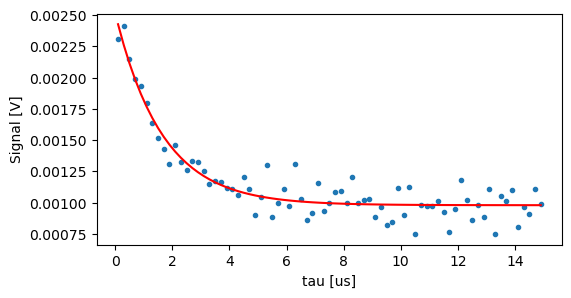

In [9]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")